Hi, I'm **Bouali Kassem Anis**, an **MSc Student in Computer Science** at the **University of Debrecen**. 
I'm excited to share my smile detection Jupyter notebook with you!


Let's start by importing the required packages. Open a new file, name it training.py, and put the following code:





In [ ]:
from __future__ import print_function
from tensorflow.keras.utils import img_to_array
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow
import os
import sys
import tarfile
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import random
import hashlib

Now, we are loading our SMILES dataset:

In [ ]:
!unzip -q /content/smile_data.zip -d /content/data/

The code below defines the variables and functions required for loading and pickling image data. The load_image function loads images for a single label and returns a dataset. The maybe_pickle function pickles the image data in the given folders only if a pickled file does not already exist for the folder or if force is True. The pickled file names are returned as a list. The code then calls maybe_pickle for the train and test folders, and stores the resulting file names in train_datasets and test_datasets respectively.

In [ ]:
num_classes = 2
train_folders = ['data/datasets/train_folder/0', 'data/datasets/train_folder/1']
test_folders = ['data/datasets/train_folder/0', 'data/datasets/test_folder/1']

image_size = 64
pixel_depth = 255.0
image_depth = 3

def load_image(folder, min_num_images):
  """Load the image for a single smile/non-smile lable."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size, image_depth),
                         dtype=np.float32)
  image_index = 0
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      image_data = (cv2.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
      # print(image_data)
      if image_data.shape != (image_size, image_size, image_depth):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    """
    Pickles the image data in the given folders, if a pickled file does not already exist
    for the folder or if force is True.
    
    Args:
        data_folders: A list of strings representing the paths to the folders containing
            the image data.
        min_num_images_per_class: An integer specifying the minimum number of images that
            a class should have to be included in the pickled dataset.
        force: A boolean indicating whether to force the pickling even if a pickled file
            already exists for a folder.
            
    Returns:
        A list of strings representing the names of the pickled files.
    """
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print(f"{set_filename} already exists. Skipping pickling.")
        else:
            print(f"Pickling {set_filename}...")
            dataset = load_image(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print(f"Unable to save data to {set_filename}: {e}")
    
    return dataset_names


train_datasets = maybe_pickle(train_folders, 1200)
test_datasets = maybe_pickle(test_folders, 500)

Pickling data/datasets/train_folder/0.pickle...
Full dataset tensor: (1238, 64, 64, 3)
Mean: -0.033598635
Standard deviation: 0.24754465
Pickling data/datasets/train_folder/1.pickle...
Full dataset tensor: (1562, 64, 64, 3)
Mean: -0.013799479
Standard deviation: 0.24923187
data/datasets/train_folder/0.pickle already exists. Skipping pickling.
Pickling data/datasets/test_folder/1.pickle...
Full dataset tensor: (600, 64, 64, 3)
Mean: -0.0034545695
Standard deviation: 0.24946716


This code defines two functions: make_arrays(nb_rows, img_size, img_depth=3) and merge_datasets(pickle_files, train_size, valid_size=0), and then uses these functions to create and merge datasets for a smile detection project.

The make_arrays function creates two NumPy arrays, dataset and labels, of shapes (nb_rows, img_size, img_size, img_depth) and (nb_rows,), respectively, with the specified data types.

The merge_datasets function takes a list of pickle files, pickle_files, and two integer values, train_size and valid_size, to create a merged dataset for the given files. The function creates empty NumPy arrays for the validation and training datasets and their labels, and then fills them with the contents of the given pickle files using a for loop. The function returns four NumPy arrays, valid_dataset, valid_labels, train_dataset, and train_labels, which represent the validation and training datasets and their corresponding labels.

The final lines of the code call the merge_datasets function twice, once for the training dataset and once for the test dataset, to create four NumPy arrays for the training and test datasets and their corresponding labels. The shapes of these arrays are then printed using the shape attribute of NumPy arrays.

In [ ]:
def make_arrays(nb_rows, img_size, img_depth=3):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size, img_depth), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels


def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class

    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                smile_nonsmile_set = pickle.load(f)
                np.random.shuffle(smile_nonsmile_set)

                if valid_dataset is not None:
                    valid_smile_nonsmile = smile_nonsmile_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_smile_nonsmile
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_smile_nonsmile = smile_nonsmile_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_smile_nonsmile
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class

        except Exception as e:
            print(f"Unable to process data from {pickle_file}: {e}")
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels


# train_size = 2800
train_size = 2400
valid_size = 600
test_size = 600

_, _, train_dataset, train_labels = merge_datasets(train_datasets, train_size)
valid_dataset, valid_labels, test_dataset, test_labels = merge_datasets(test_datasets, test_size, valid_size)

print(f"Training: {train_dataset.shape}, {train_labels.shape}")
print(f"Validation: {valid_dataset.shape}, {valid_labels.shape}")
print(f"Testing: {test_dataset.shape}, {test_labels.shape}")


Training: (2400, 64, 64, 3), (2400,)
Validation: (600, 64, 64, 3), (600,)
Testing: (600, 64, 64, 3), (600,)


This code defines a function called randomize that takes in two arguments: dataset and labels. It then uses the np.random.permutation function from NumPy to generate a random permutation of integers between 0 and the number of labels in the labels array. It uses this permutation to shuffle the rows of the dataset array and the labels array in the same way. It then returns the shuffled dataset and labels.

After defining the randomize function, it is called three times to shuffle the training, testing, and validation datasets and labels using the train_dataset, train_labels, test_dataset, test_labels, valid_dataset, and valid_labels arrays that were previously generated using the merge_datasets function. The shuffled datasets and labels are then assigned back to the same variables.

In [ ]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

This code saves the datasets and labels into a pickle file, which is a serialized representation of the data that can be easily loaded later on. The code starts by defining the name of the pickle file to be saved as 'my_pickle_file.pickle'. It then opens the file in write binary mode ('wb') and creates a dictionary called 'save' that contains the train, validation, and test datasets and labels. The dictionary is then serialized using the 'pickle' module and saved to the file using the 'dump' method.

After the data is saved, the code uses the 'os.stat' function to get the file size of the saved pickle file and prints it to the console. This can be helpful to ensure that the saved file is of a reasonable size and can be easily loaded later on. If an error occurs during the save operation, the code prints an error message to the console and raises the exception.

In [ ]:
pickle_file = 'my_pickle_file.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 176962034


In [ ]:
num_labels = 2
num_channels = image_depth # 3 is (RGB)
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (2400, 64, 64, 3) (2400, 2)
Validation set (600, 64, 64, 3) (600, 2)
Test set (600, 64, 64, 3) (600, 2)


This code defines a function to calculate the accuracy of a prediction given the actual labels.



In [ ]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

The following code trains a convolutional neural network (CNN) to classify images from the CIFAR-10 dataset. The model consists of two convolutional layers, two max pooling layers, one fully connected hidden layer, and one output layer. The optimizer used is stochastic gradient descent (SGD) with a learning rate of 0.05 and the loss function used is categorical cross-entropy. The model is trained for a specified number of steps, with the minibatch size and number of epochs calculated based on the training set size. After each step, the model's performance is evaluated on a validation set and the minibatch loss and accuracy are printed. Finally, the model's accuracy is evaluated on a test set.

In [ ]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
num_steps = 1001
num_train_samples = train_dataset.shape[0]
iterations_per_epoch = num_train_samples // batch_size
num_epochs = num_steps // iterations_per_epoch

model = Sequential()

# Conv layer 1
model.add(Conv2D(depth, (patch_size, patch_size), activation='relu', padding='same',
                 input_shape=(image_size, image_size, num_channels)))
# Max pooling layer 1
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Conv layer 2
model.add(Conv2D(depth, (patch_size, patch_size), activation='relu', padding='same'))
# Max pooling layer 2
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Flatten the output of the last convolutional layer
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(num_hidden, activation='relu'))

# Output layer
model.add(Dense(num_labels, activation='softmax'))

# Define the optimizer and loss function
sgd = SGD(lr=0.05)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
for step in range(num_steps):
    offset = (step * batch_size) % (num_train_samples - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    loss, accuracy = model.train_on_batch(batch_data, batch_labels)

    if step % 50 == 0:
        print('Minibatch loss at step %d: %f' % (step, loss))
        print('Minibatch accuracy: %.1f%%' % (accuracy * 100))
        valid_accuracy = model.evaluate(valid_dataset, valid_labels, verbose=0)[1]
        print('Validation accuracy: %.1f%%' % (valid_accuracy * 100))

        # Print the number of epochs
        current_epoch = (step * batch_size) // num_train_samples 
        print('Epoch %d/%d' % (current_epoch, num_epochs))
        print('------------------')

# Test the model
test_accuracy = model.evaluate(test_dataset, test_labels, verbose=0)[1]
print('Test accuracy: %.1f%%' % (test_accuracy * 100))


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Minibatch loss at step 0: 0.692889
Minibatch accuracy: 56.2%
Validation accuracy: 50.7%
Epoch 0/6
------------------
Minibatch loss at step 50: 0.661880
Minibatch accuracy: 68.8%
Validation accuracy: 62.2%
Epoch 0/6
------------------
Minibatch loss at step 100: 0.721449
Minibatch accuracy: 62.5%
Validation accuracy: 65.8%
Epoch 0/6
------------------
Minibatch loss at step 150: 0.729629
Minibatch accuracy: 50.0%
Validation accuracy: 74.8%
Epoch 1/6
------------------
Minibatch loss at step 200: 0.471797
Minibatch accuracy: 93.8%
Validation accuracy: 77.7%
Epoch 1/6
------------------
Minibatch loss at step 250: 0.871049
Minibatch accuracy: 31.2%
Validation accuracy: 70.3%
Epoch 1/6
------------------
Minibatch loss at step 300: 0.336314
Minibatch accuracy: 75.0%
Validation accuracy: 79.7%
Epoch 2/6
------------------
Minibatch loss at step 350: 0.444426
Minibatch accuracy: 81.2%
Validation accuracy: 67.5%
Epoch 2/6
------------------
Minibatch loss at step 400: 0.552473
Minibatch accu

This function takes a photo using the computer's camera and saves it to a file. The filename parameter specifies the name of the file to save the photo as, and the quality parameter specifies the quality of the image to be saved. It uses JavaScript to display a video stream from the camera, and then captures a frame from the video stream when the user clicks a "Capture" button. The captured image is then saved as a JPEG file using the specified filename and quality.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

The code above captures a photo using the webcam and displays it in the notebook using the IPython Image class.

Here's an explanation of the code:

The take_photo function uses JavaScript to capture a photo using the webcam and returns the captured image as a base64 encoded data URL.

The Image class from IPython.display is imported.

The try block calls the take_photo function and saves the captured image to a file.

The saved image is displayed using the Image class.

If an exception is thrown, the error message is printed.

<IPython.core.display.Javascript object>

Saved to photo.jpg


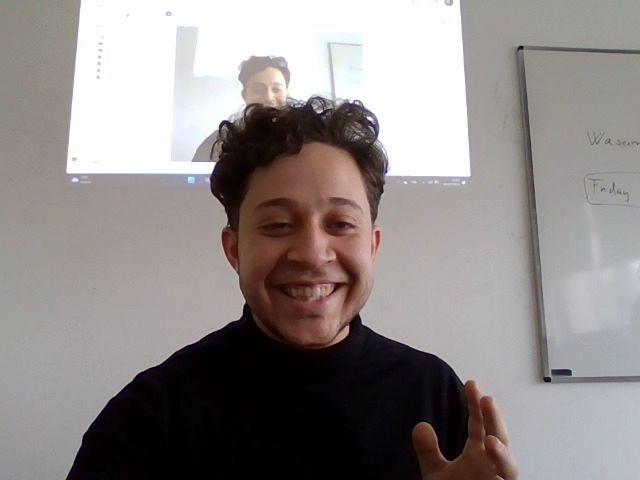

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

This code performs face detection on an input image using the OpenCV library and a pre-trained Haar cascade classifier for face detection. It then extracts the region of interest (ROI) corresponding to each detected face, resizes it to a fixed size, and feeds it into a pre-trained CNN model to classify whether the person in the image is smiling or not. The classification result is then displayed on the output image along with the bounding box around each detected face.

1/1 [==============================] - 0s 125ms/step
Smiling 0.65%


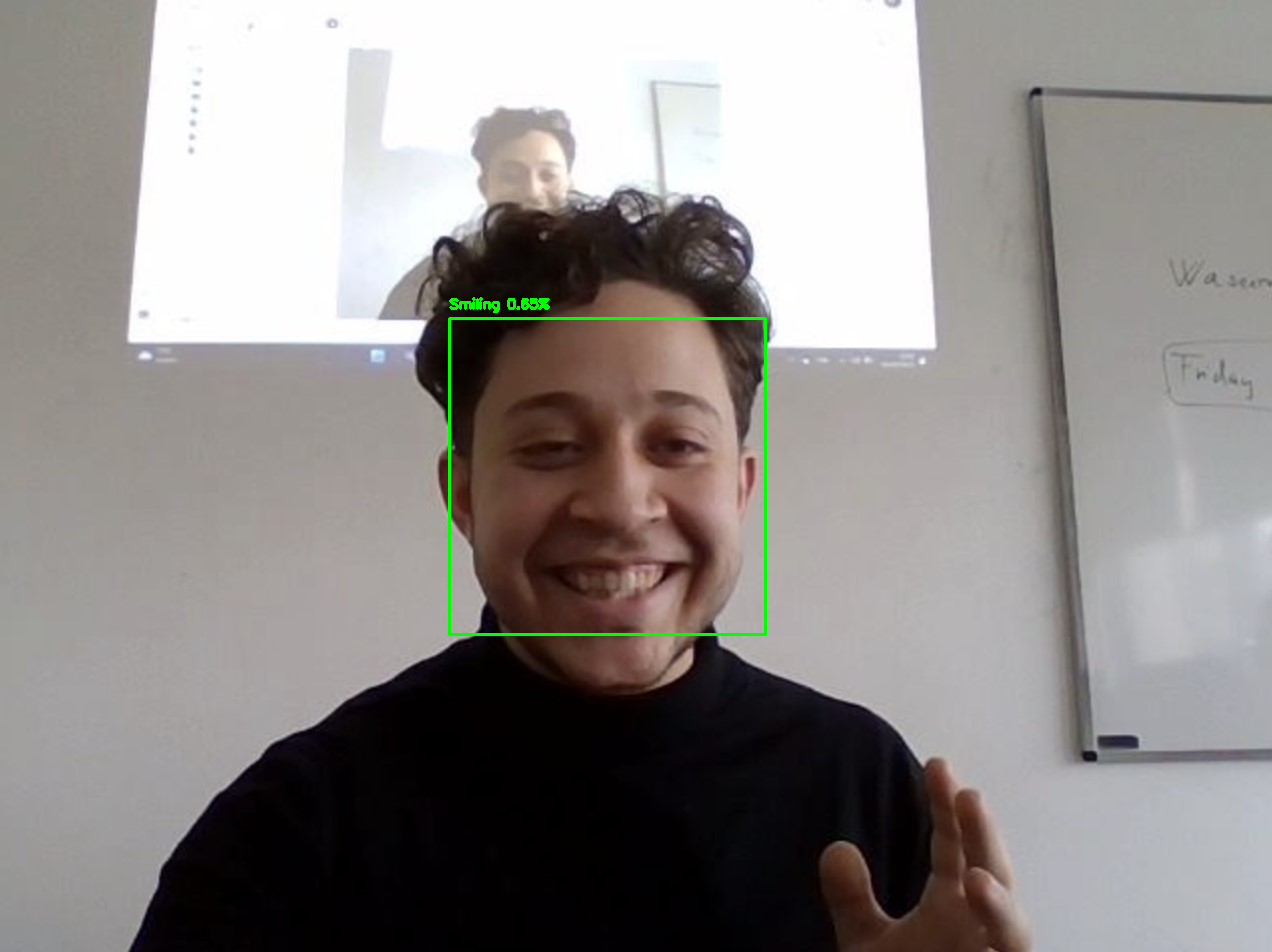

In [ ]:
detector = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

# resize the fram, convert it to grayscale, and then clone the
# orgignal frame so we draw on it later in the program
frame = cv2.imread('/content/hi.jpg')
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frameClone = frame.copy()

# detect faces in the input frame, then clone the frame so that we can draw onit
rects = detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

for (fX, fY, fW, fH) in rects:
    # extract the ROI of the face from the grayscale image
    # resize it to a fixed 28x28 pixels, and then prepare the
    # ROI for classification via the CNN
    roi = frame[fY:fY + fH, fX:fX + fW]
    roi = cv2.resize(roi, (64, 64))
    roi = roi.astype('float') / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # determine the probaboilities of both 'smiling' and 'not smiling',
    # then set the label accordingly
    (notSmiling, Smiling) = model.predict(roi)[0]
    label = "Smiling " + "{:.2f}%".format(Smiling) if Smiling > notSmiling else "Not Smiling " + "{:.2f}%".format(notSmiling)
    print(label)
    # display the label and bounding box on the output frame
    if label == "Smiling " + "{:.2f}%".format(Smiling):
        cv2.putText(frameClone, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH), (0, 255, 0), 2)
    else:
        cv2.putText(frameClone, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH), (0, 0, 255), 2)

cv2_imshow(frameClone)